In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Vista exprés 2 D (corte z = const.) del dominio OpenFOAM con obstáculos circulares
Autor: (tu nombre) · Abril 2025
"""

import os
import pyvista as pv

# ──────────────────────────────────────────────────────────────
# 1) RUTA DEL VTK
# ──────────────────────────────────────────────────────────────
case_dir = os.path.expanduser("~/OpenFOAM/jose-v2406/run/YDRAY-flow_n13_sat")
vtk_file = os.path.join(case_dir, "VTK", "YDRAY-flow_n13_sat_1047.vtm")

# ──────────────────────────────────────────────────────────────
# 2) CARGA Y BLOQUES
# ──────────────────────────────────────────────────────────────
mb        = pv.read(vtk_file)
vol_mesh  = mb["internal"]
cyl_patch = mb["boundary"]["wallFluidSolid"]

# ──────────────────────────────────────────────────────────────
# 3) PLANO DE CORTE
# ──────────────────────────────────────────────────────────────
_, _, _, _, zmin, zmax = vol_mesh.bounds
z_mid = 0.5 * (zmin + zmax)

obst_section = (
    cyl_patch.extract_surface()
             .slice(normal="z", origin=(0, 0, z_mid))
             .clean()
)
dom_section = (
    vol_mesh.extract_surface()
            .slice(normal="z", origin=(0, 0, z_mid))
            .clean()
)

print(f"Obstáculos en corte: {obst_section.n_lines:,d} aristas")



Obstáculos en corte: 800,462 aristas


/home/jose/.local/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


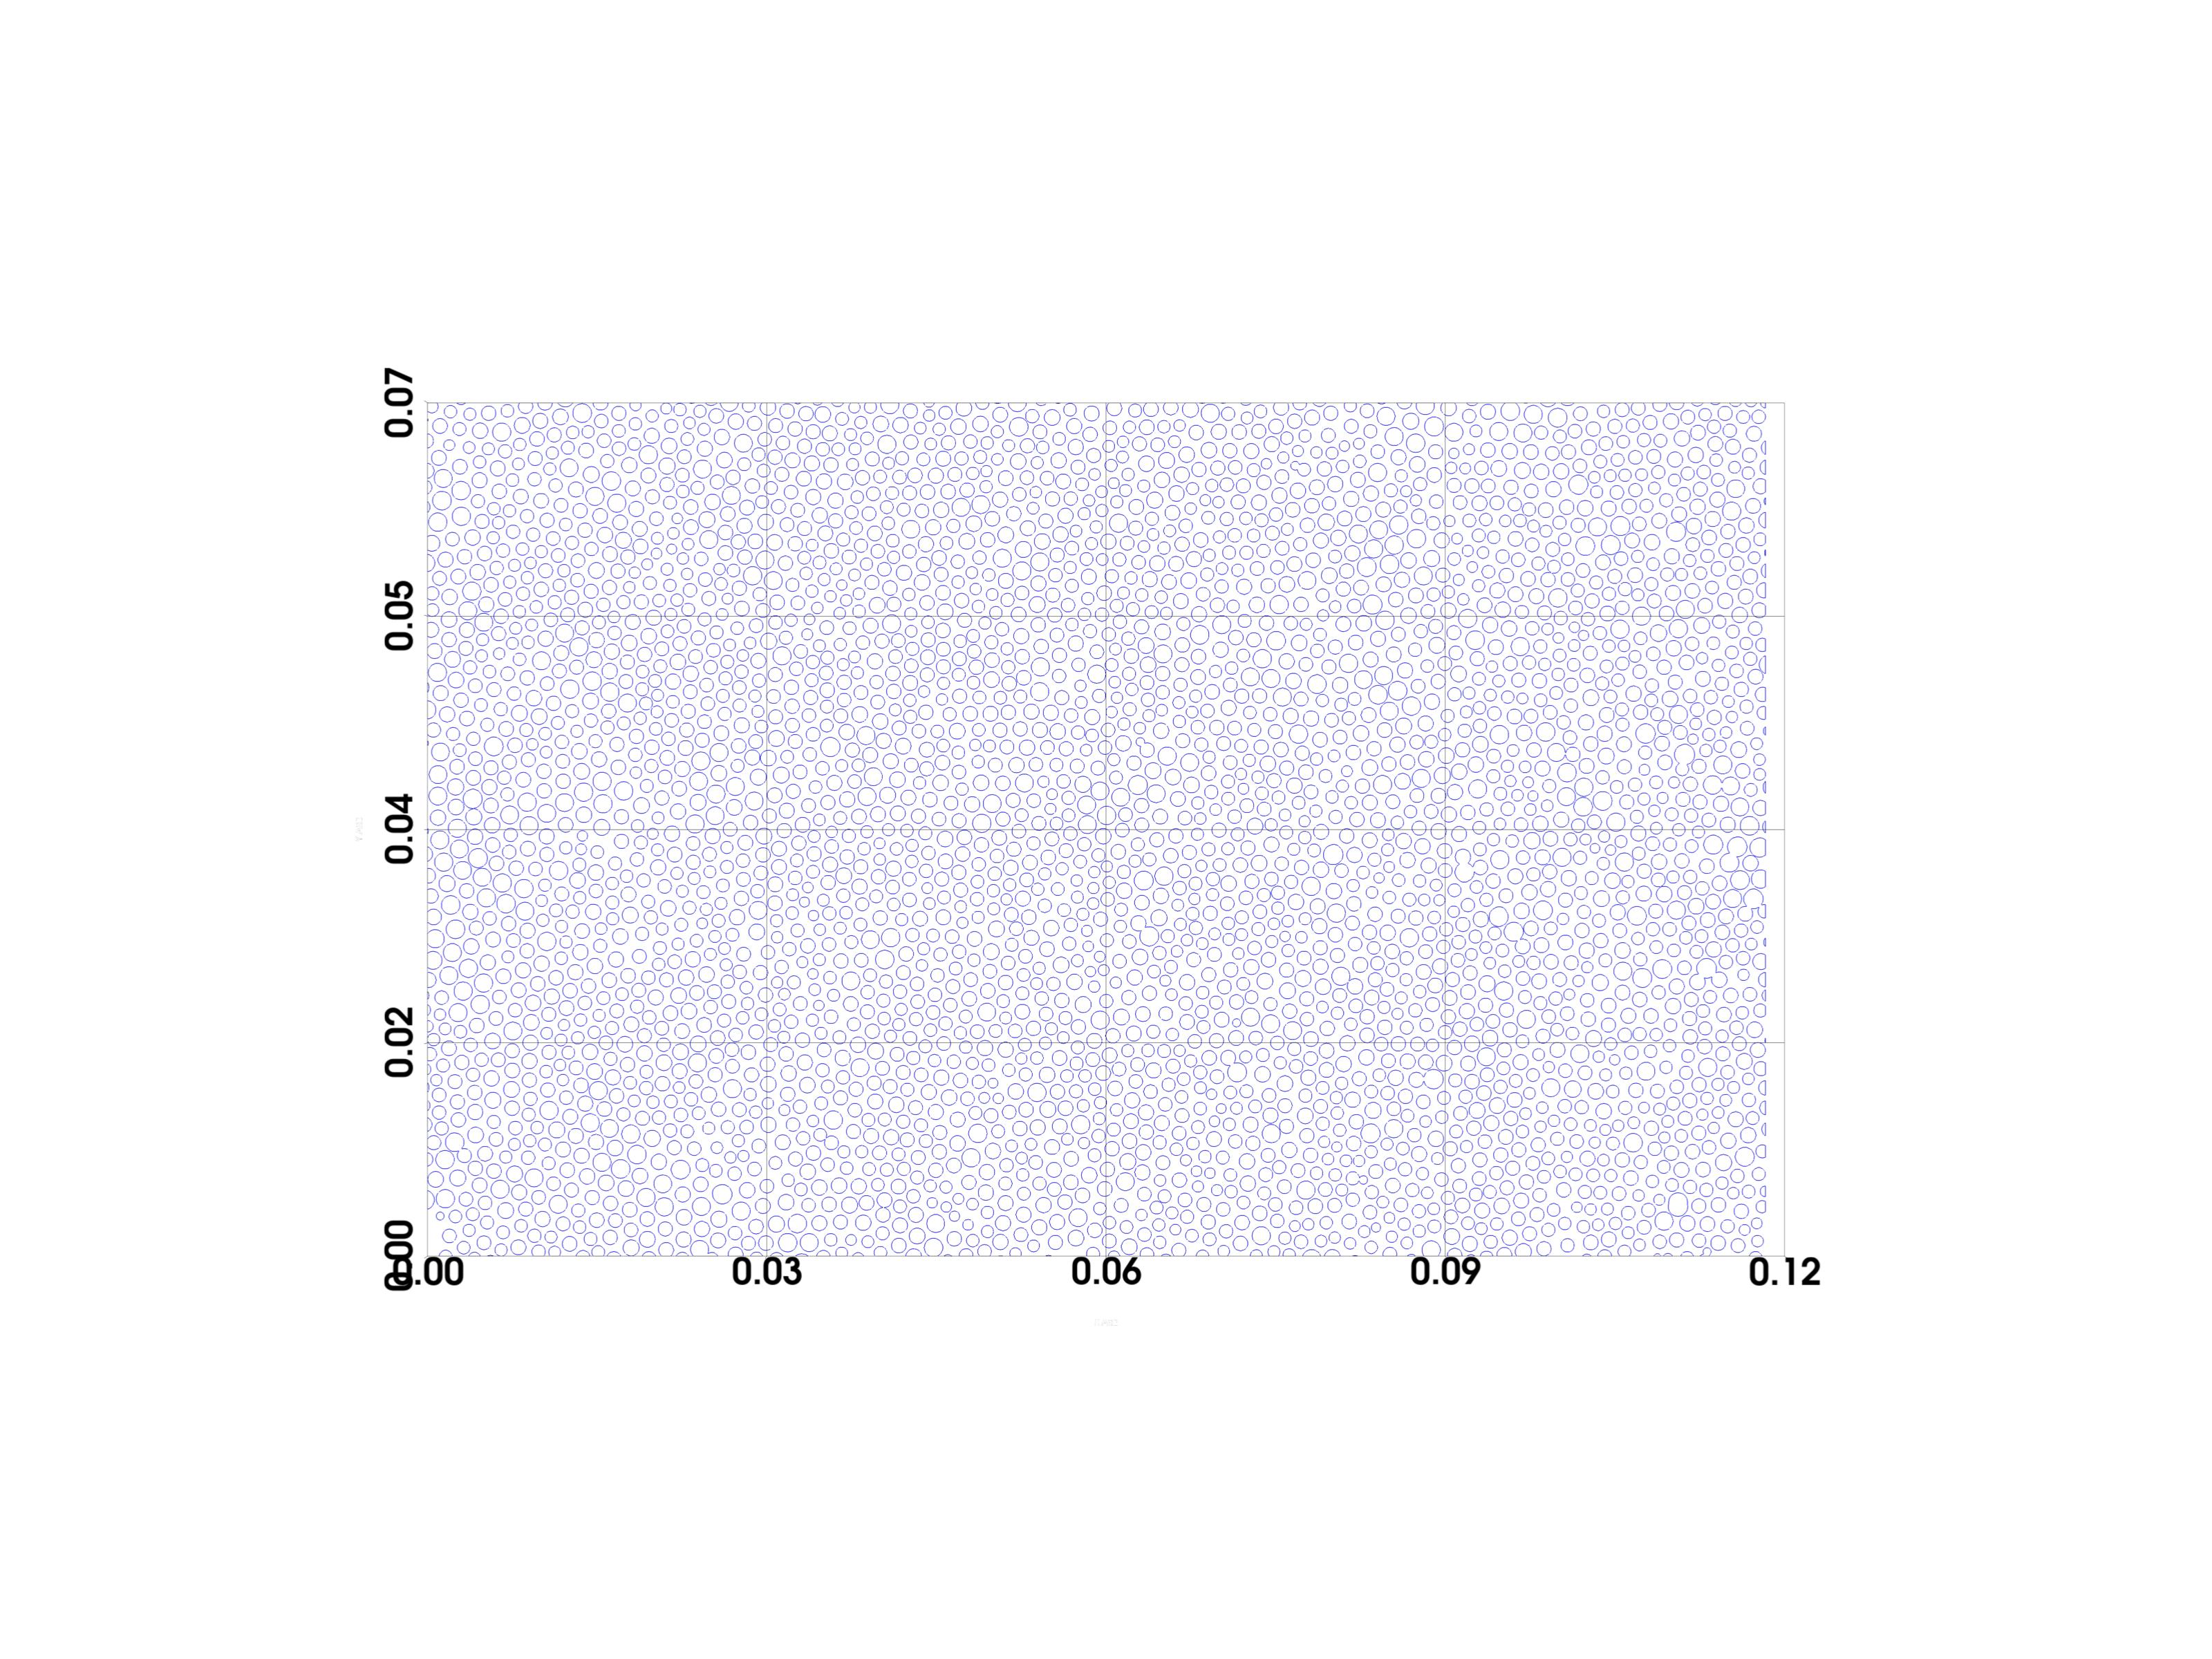

In [26]:

# VISUALIZACIÓN

WINDOW_SIZE = (3200, 2400)   # resolución ventana
AXIS_FONT   = 40              # tamaño de números

pl = pv.Plotter(window_size=WINDOW_SIZE)
pl.set_background("white")

pl.add_mesh(obst_section, color="blue",  line_width=1.5, label="Obstacles")
pl.add_mesh(dom_section,  color="gray", line_width=0.8, opacity=0.4,
            label="Domain boundary")



axes = pl.show_bounds(grid="front", fmt="%.2f", font_size=AXIS_FONT)


axes.x_label_offset = 400    # mueve los números del eje X hacia abajo
axes.y_label_offset = 400    # mueve los números del eje Y hacia la izquierda

pl.view_xy()

pl.show(window_size=WINDOW_SIZE)

# ───────────────────────── 5)  CAPTURA OPCIONAL ──────────────────────────────
# pl.screenshot("obstaculos_corte2D_hires.png",
#               window_size=(3200, 2400),
#               transparent_background=True)


In [14]:
# ──────────────────────────────────────────────────────────────
# 6)  HISTOGRAMA DE APERTURAS ENTRE CILINDROS
# ──────────────────────────────────────────────────────────────
import itertools
import numpy as np
import matplotlib.pyplot as plt

# 6.1  Etiqueta cada cilindro (conectividad → RegionId)
conn    = obst_section.connectivity()      # genera un array 'RegionId'
regions = np.unique(conn["RegionId"])

centers = []
radii   = []

for rid in regions:
    # Extrae sólo la región 'rid' (no todas ≥ rid)
    cyl = conn.threshold((rid, rid), scalars="RegionId")
    pts = cyl.points[:, :2]

    # Descartar regiones muy pequeñas
    if len(pts) < 30:
        continue

    # Centroide provisional
    c = pts.mean(axis=0)

    # Distancias de los puntos al centro
    dists = np.linalg.norm(pts - c, axis=1)

    # Radio robusto: percentil 90 (no el 10)
    r = np.percentile(dists, 90)

    # Filtro de tamaño razonable (opcional)
    if r > 0.02:
        continue

    centers.append(c)
    radii.append(r)

centers = np.array(centers)
radii   = np.array(radii)

print(f"Se detectaron {len(centers)} cilindros en el corte")

# 6.2  Calcula aperturas entre todas las parejas de cilindros
aperturas = []
for i, j in itertools.combinations(range(len(centers)), 2):
    d = np.linalg.norm(centers[i] - centers[j])
    a = d - (radii[i] + radii[j])
    if a > 0 and a < 0.9*(radii[i] + radii[j]):                      # sólo aperturas (sin solapes ni tangencias)
        aperturas.append(a)

aperturas = np.array(aperturas)
print(f"Nº de aperturas encontradas: {aperturas.size}")


Se detectaron 3530 cilindros en el corte
Nº de aperturas encontradas: 10481


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

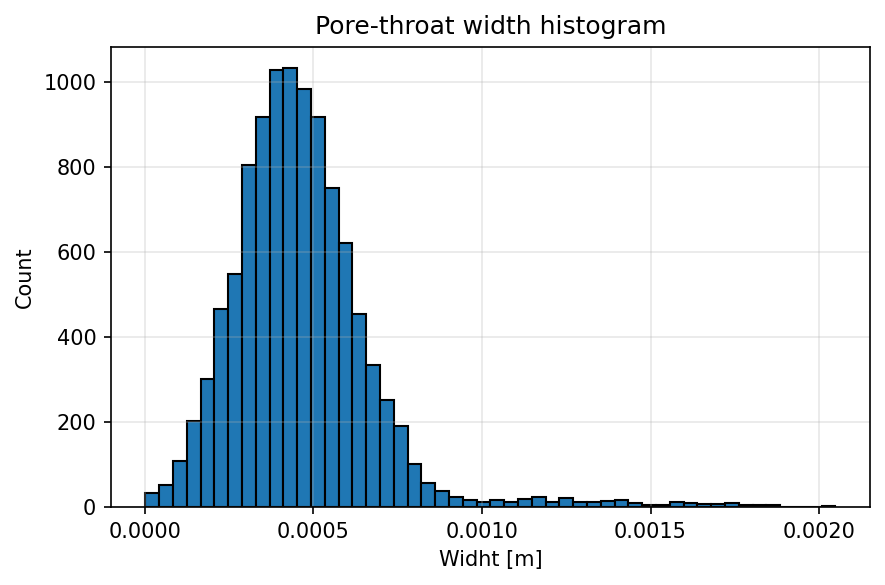

In [18]:


# 6.3  Histograma de aperturas
n_bins = 50  # o p.ej. 20

plt.figure(figsize=(6, 4), dpi=150)
plt.hist(aperturas, bins=n_bins, edgecolor="k")
plt.xlabel("Widht [m]")
plt.ylabel("Count")
plt.title(f"Pore-throat width histogram")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/home/jose/.local/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


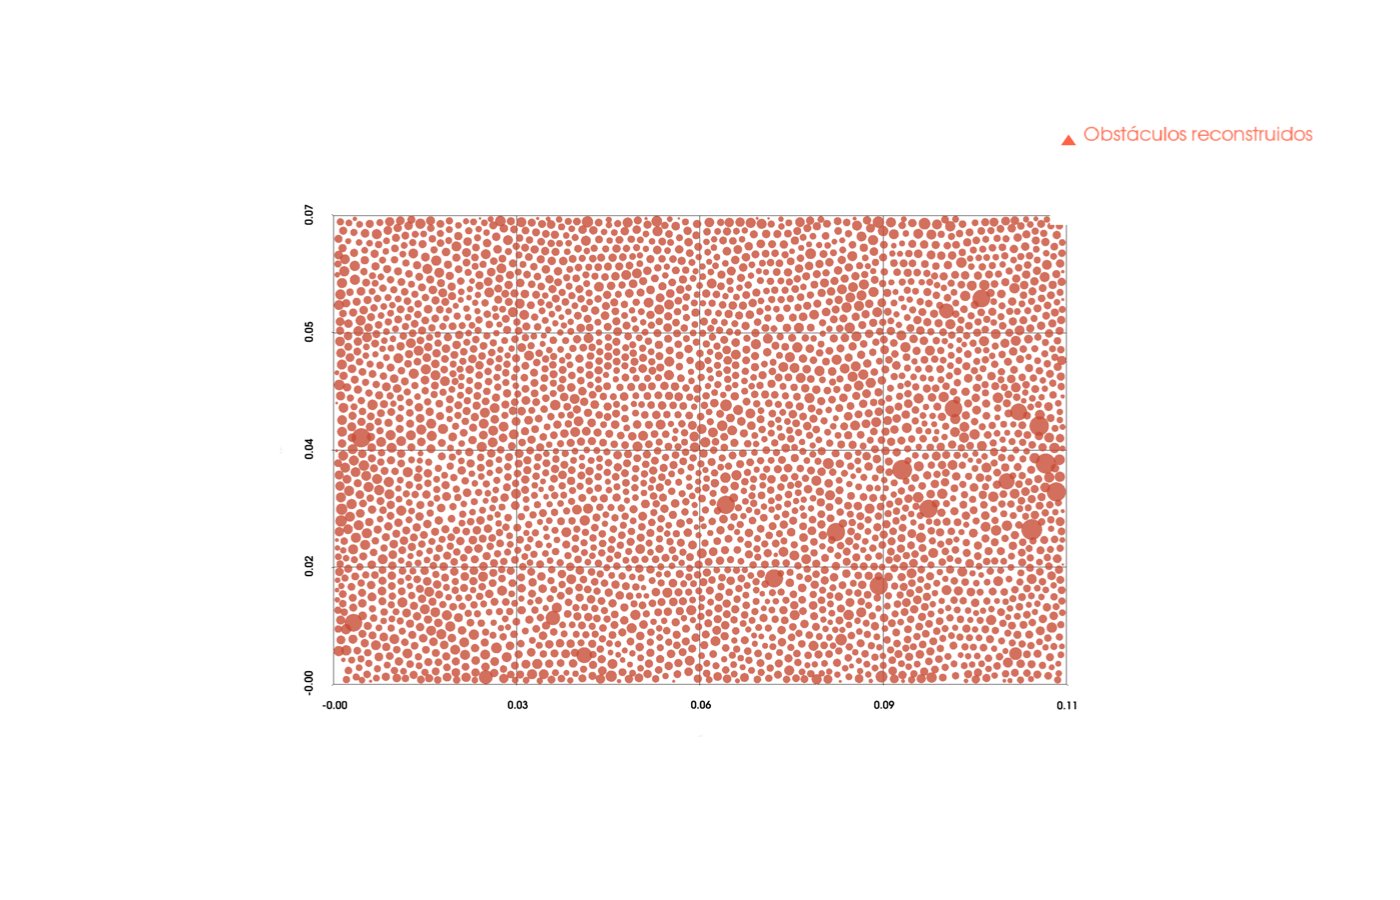

In [16]:
# ──────────────────────────────────────────────────────────────
# 7)  VISUALIZACIÓN SOLO DE LOS OBSTÁCULOS RECONSTRUIDOS
# ──────────────────────────────────────────────────────────────
import pyvista as pv

# (opcional) Si prefieres “pastillas” 3-D en lugar de discos planos, activa:
EXTRUDE = False          # True → extruye 2 cm en +Z

discs = []
for (x, y), r in zip(centers, radii):
    disc = pv.Disc(inner=0.0, outer=r, r_res=1, c_res=64)
    if EXTRUDE:
        disc = disc.extrude([0, 0, 0.02])        # 0.02 m de espesor
    disc.translate([x, y, z_mid], inplace=True)  # coloca en su posición
    discs.append(disc)

# Unir todos los discos/cilindros en un único objeto
obstacles_new = pv.MultiBlock(discs).combine()

# Plotter
pl = pv.Plotter(window_size=(1400, 900))
pl.set_background("white")

pl.add_mesh(
    obstacles_new,
    color="tomato",
    opacity=0.8,
    smooth_shading=True,
    label="Obstáculos reconstruidos"
)

pl.view_xy()
pl.show_bounds(grid="front", fmt="%.2f", font_size=8)
pl.add_legend(bcolor="white").GetEntryTextProperty().SetFontSize(8)

pl.show(title="Obstáculos reconstruidos (centro + radio)")
